In [1]:
import requests
import json

# To run this, create a credentials.py file containing your credentials
# CREDENTIALS = {'user':'???', 'password':'???'}

from credentials import CREDENTIALS, AUTH_URL

In [46]:
# The s=requests parameter is designed to default to using requests
# for requests.get, requests.post, etc.
# To use HTTP Persistent connections, pass a requests.Session() object  as s

def get_storage_url_and_token(s=requests):
    storage_url = 'removed'
    auth_token = 'removed'
    return storage_url, auth_token

def headers(auth_token):
    return {'X-Auth-Token': auth_token}

def make_container(storage_url, auth_token, name, s=requests):
    dest_url =  '{}/{}'.format(storage_url, name)
    response = s.put(dest_url, headers=headers(auth_token))
    response.raise_for_status()

def upload_object(storage_url, auth_token, container, name, content, s=requests):
    dest_url = '{}/{}/{}'.format(storage_url, container, name)
    headers_dict = headers(auth_token)
    headers_dict['Content-Type'] = 'text/plain'
    response = s.put(dest_url, headers=headers_dict, data=content)
    response.raise_for_status()
    # Need to return etags and sizes
    return dict(etag=response.headers['Etag'], path='{}/{}'.format(container, name), size_bytes=len(content))

# Put a manifest
def make_slo(storage_url, auth_token, container, dest_name, manifest_entries, s=requests):
    dest_url = '{}/{}/{}'.format(storage_url, container, dest_name)
    response = s.put(dest_url, params={'multipart-manifest':'put'}, data=json.dumps(manifest_entries), headers=headers(auth_token))
    response.raise_for_status()

def get_object(storage_url, auth_token, container, name, s=requests):
    dest_url = '{}/{}/{}'.format(storage_url, container, name)
    response = s.get(dest_url, headers=headers(auth_token))
    return response.text


In [3]:
def make_containers(count, s=requests):
    for i in range(count):
        make_container(storage_url, token, 'container{}'.format(i), s)

def make_objects(container_i, count, size, s=requests):
    manifest_entries = []
    for i in range(count):
        file_name = 'file{}.txt'.format(i)
        contents = 'file{}'.format(i)
        manifest_entry = upload_object(storage_url, token, 'container{}'.format(container_i), file_name, 'x' * size, s)
        manifest_entries.append(manifest_entry)
    return manifest_entries

def make_slos(container_i, count, manifest_entries, s=requests):
    for i in range(count):
        make_slo(storage_url, token, 'container{}'.format(container_i), 'slo{}.txt'.format(i), manifest_entries, s)

## Configure requests

In [15]:
%time storage_url, token = get_storage_url_and_token()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


## 10 Containers,  10 10k objects , 1 SLO
### With request.session()

In [17]:
s = requests.Session()

In [23]:
%time make_containers(10, s)

CPU times: user 35.3 ms, sys: 4.12 ms, total: 39.4 ms
Wall time: 1.04 s


In [31]:
%time manifest_entries = make_objects(0, 10, 10, s)

CPU times: user 41.8 ms, sys: 4.33 ms, total: 46.2 ms
Wall time: 1.21 s


In [32]:
manifest_entries

[{'etag': '336311a016184326ddbdd61edd4eeb52',
  'path': 'container0/file0.txt',
  'size_bytes': 10},
 {'etag': '336311a016184326ddbdd61edd4eeb52',
  'path': 'container0/file1.txt',
  'size_bytes': 10},
 {'etag': '336311a016184326ddbdd61edd4eeb52',
  'path': 'container0/file2.txt',
  'size_bytes': 10},
 {'etag': '336311a016184326ddbdd61edd4eeb52',
  'path': 'container0/file3.txt',
  'size_bytes': 10},
 {'etag': '336311a016184326ddbdd61edd4eeb52',
  'path': 'container0/file4.txt',
  'size_bytes': 10},
 {'etag': '336311a016184326ddbdd61edd4eeb52',
  'path': 'container0/file5.txt',
  'size_bytes': 10},
 {'etag': '336311a016184326ddbdd61edd4eeb52',
  'path': 'container0/file6.txt',
  'size_bytes': 10},
 {'etag': '336311a016184326ddbdd61edd4eeb52',
  'path': 'container0/file7.txt',
  'size_bytes': 10},
 {'etag': '336311a016184326ddbdd61edd4eeb52',
  'path': 'container0/file8.txt',
  'size_bytes': 10},
 {'etag': '336311a016184326ddbdd61edd4eeb52',
  'path': 'container0/file9.txt',
  'size_byt

In [33]:
%time make_slos(0, 1, manifest_entries, s)

CPU times: user 4.01 ms, sys: 1.35 ms, total: 5.36 ms
Wall time: 173 ms


- making a container takes 100ms
- making an object doesn't seem to depend on the file size under 10,000 bytes. 140ms
- making a SLO depends on the number of objects and their size but takes a minimum 170ms

## 1 Container, 50 objects, 1 SLO

In [35]:
%time make_containers(1, s)
%time manifest_entries = make_objects(1, 50, 10000, s)
%time make_slos(1, 1, manifest_entries, s)

CPU times: user 4.54 ms, sys: 3.43 ms, total: 7.97 ms
Wall time: 116 ms
CPU times: user 207 ms, sys: 17.5 ms, total: 224 ms
Wall time: 8.81 s
CPU times: user 5.02 ms, sys: 733 µs, total: 5.75 ms
Wall time: 451 ms


- Creating a container took 116ms
- making 50 objects took 8.81s, so 176ms each
- making a SLO of 50 objects took 451ms

In [36]:
manifest_entries_10k = make_objects(2, 100, 10000, s)
sizes = []
for i in range(0,100,10):
    subset = manifest_entries[:i+10]
    sizes.append(len(subset))
    %time make_slos(3, 1, subset, s)

CPU times: user 3.62 ms, sys: 327 µs, total: 3.95 ms
Wall time: 207 ms
CPU times: user 4.33 ms, sys: 641 µs, total: 4.97 ms
Wall time: 216 ms
CPU times: user 3.31 ms, sys: 458 µs, total: 3.77 ms
Wall time: 247 ms
CPU times: user 3.74 ms, sys: 508 µs, total: 4.24 ms
Wall time: 305 ms
CPU times: user 3.99 ms, sys: 473 µs, total: 4.47 ms
Wall time: 345 ms
CPU times: user 4.28 ms, sys: 683 µs, total: 4.96 ms
Wall time: 355 ms
CPU times: user 4.89 ms, sys: 752 µs, total: 5.64 ms
Wall time: 346 ms
CPU times: user 4.89 ms, sys: 657 µs, total: 5.55 ms
Wall time: 370 ms
CPU times: user 4.5 ms, sys: 539 µs, total: 5.04 ms
Wall time: 365 ms
CPU times: user 4.41 ms, sys: 479 µs, total: 4.89 ms
Wall time: 341 ms


In [37]:
times = [207,216,247,305,345,355,346,370,365,341]

In [38]:
import matplotlib

In [39]:
%matplotlib inline

In [40]:
from matplotlib.pyplot import plot

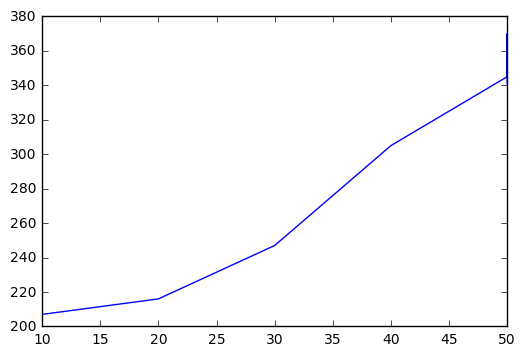

In [41]:
plot(sizes, times)

## Timing GET of 10 objects

In [42]:
%%time

for i in range(10):
    get_object(storage_url, token, 'container1','file{}.txt'.format(i), s)

CPU times: user 43.8 ms, sys: 6.64 ms, total: 50.4 ms
Wall time: 1.37 s


## Timing GET of /info

In [43]:
%%time
for i in range(10):
     s.get('https://swift.oit.duke.edu/info')

CPU times: user 170 ms, sys: 12.4 ms, total: 182 ms
Wall time: 1.55 s


## Confirming with bash

In [44]:
%%bash

time curl https://dal.objectstorage.open.softlayer.com/info


{"formpost": {}, "bulk_delete": {"max_failed_deletes": 1000, "max_deletes_per_request": 10000}, "versioned_writes": {}, "container_quotas": {}, "tempurl": {"outgoing_remove_headers": ["x-object-meta-*"], "incoming_remove_headers": ["x-timestamp"], "incoming_allow_headers": [], "methods": ["GET", "HEAD", "PUT", "POST", "DELETE"], "outgoing_allow_headers": ["x-object-meta-public-*"]}, "bulk_upload": {"max_failed_extractions": 1000, "max_containers_per_extraction": 10000}, "slo": {"max_manifest_segments": 1000, "min_segment_size": 1, "max_manifest_size": 2097152}, "account_quotas": {}, "staticweb": {}, "swift": {"max_file_size": 5368709122, "account_listing_limit": 10000, "account_autocreate": true, "max_meta_count": 90, "max_meta_value_length": 256, "container_listing_limit": 10000, "extra_header_count": 0, "max_meta_overall_size": 4096, "version": "2.7.0.post11", "max_meta_name_length": 128, "max_header_size": 8192, "policies": [{"default": true, "name": "standard", "aliases": "standard

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1201  100  1201    0     0   3420      0 --:--:-- --:--:-- --:--:--  3617

real	0m0.362s
user	0m0.016s
sys	0m0.004s


## Ping/latency info

In [45]:
%%bash

ping -c 10 dal.objectstorage.open.softlayer.com

PING dal.objectstorage.open.softlayer.com (173.192.119.147): 56 data bytes
64 bytes from 173.192.119.147: icmp_seq=0 ttl=238 time=78.679 ms
64 bytes from 173.192.119.147: icmp_seq=1 ttl=238 time=78.603 ms
64 bytes from 173.192.119.147: icmp_seq=2 ttl=238 time=78.679 ms
64 bytes from 173.192.119.147: icmp_seq=3 ttl=238 time=78.696 ms
64 bytes from 173.192.119.147: icmp_seq=4 ttl=238 time=78.690 ms
64 bytes from 173.192.119.147: icmp_seq=5 ttl=238 time=78.646 ms
64 bytes from 173.192.119.147: icmp_seq=6 ttl=238 time=78.440 ms
64 bytes from 173.192.119.147: icmp_seq=7 ttl=238 time=78.389 ms
64 bytes from 173.192.119.147: icmp_seq=8 ttl=238 time=78.395 ms
64 bytes from 173.192.119.147: icmp_seq=9 ttl=238 time=78.527 ms

--- dal.objectstorage.open.softlayer.com ping statistics ---
10 packets transmitted, 10 packets received, 0.0% packet loss
round-trip min/avg/max/stddev = 78.389/78.574/78.696/0.120 ms


On OIT desktop network, with 80ms ping to the host